In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Importing dataset
train = pd.read_csv('./train_1.csv').fillna(0)
page = train['Page']
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [3]:
import re

def get_source(page):
    res = re.search('_[a-z]+\.[a-z]+\.[a-z]+_[a-z\-]+_[a-z]+',page)
    if res:
        return res.group().split('_')[1]
    return 'na'

def get_access(page):
    res = re.search('_[a-z]+\.[a-z]+\.[a-z]+_[a-z\-]+_[a-z]+',page)
    if res:
        return res.group().split('_')[2]
    return 'na'

def get_agent(page):
    res = re.search('_[a-z]+\.[a-z]+\.[a-z]+_[a-z\-]+_[a-z]+',page)
    if res:
        return res.group().split('_')[3]
    return 'na'

source = train.Page.map(get_source)
access = train.Page.map(get_access)
agent = train.Page.map(get_agent)

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
source = le.fit_transform(source)
access = le.fit_transform(access)
agent = le.fit_transform(agent)

In [4]:
train = train.drop('Page',axis = 1)

In [5]:
source = np.reshape(source, (-1,1))
access = np.reshape(access, (-1,1))
agent = np.reshape(agent, (-1,1))

enc = preprocessing.OneHotEncoder()

source = enc.fit_transform(source)
access = enc.fit_transform(access)
agent = enc.fit_transform(agent)

In [6]:
print source.shape, train.shape

import sys



(145063, 9) (145063, 550)


In [7]:

article = 4991



rows = []


# for article in range(len(train)):
for article in range(5000):
    row = train.iloc[article,:].values
    row_len = len(row)
    row = np.reshape(row,(1,row_len))
    sourceCol = np.rot90(np.repeat(source[article,:].toarray(), row_len, axis=0),1,(0,1))
    accessCol = np.rot90(np.repeat(access[article,:].toarray(), row_len, axis=0),1,(0,1))
    agentCol = np.rot90(np.repeat(agent[article,:].toarray(), row_len, axis=0),1,(0,1))
    row = np.append(row, sourceCol, axis=0)
    row = np.append(row, accessCol, axis=0)
    row = np.append(row, agentCol, axis=0)
    rows.append(row)

rows = np.array(rows)    
print rows.shape, sys.getsizeof(rows)/(1024*1024)

(5000, 15, 550) 314


In [8]:
seq_length = 7

X = []
y = []
# for article in range(len(train)):
for article in range(5000):
    for i in range(0, len(rows[article,0]) - seq_length, 1):
        X.append(row[:,i: i + seq_length])
        y.append(row[0,i + seq_length])

    
X = np.array(X)
print X.shape, len(y), sys.getsizeof(X)/(1024*1024)

(2715000, 15, 7) 2715000 2174


In [9]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)



# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
X_train_num = np.reshape(X_train[:,0,:],(-1,1))
# print X_train[4492, 0, :], y_train[4491]
# print X_train[4491, 0, :], X_train_num[4491*7:4491*7+7, 0], y_train[4491-7:4491]
y_train = np.reshape(y_train,(-1,1))


X_train_num = sc.fit_transform(X_train_num)

y_train = sc.fit_transform(y_train)


X_train_num = np.reshape(X_train_num, (len(X_train_num)/seq_length, seq_length))

X_train[:,0,:] = X_train_num

X_train = np.rot90(X_train, 1, (2, 1))

print X_train.shape

(2172000, 7, 15)


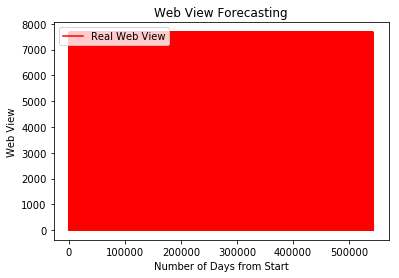

In [10]:
#Visualising Result
plt.figure
plt.plot(y_test, color = 'red', label = 'Real Web View')
# plt.plot(y_pred, color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()

In [11]:
# Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the input layerand the LSTM layer
regressor.add(LSTM(units = 32, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 16, epochs = 10, verbose = 1)

Using TensorFlow backend.


Epoch 1/10
2172000/2172000 [==============================] - 835s - loss: 3.0419e-04   
Epoch 2/10
2172000/2172000 [==============================] - 839s - loss: 8.6745e-05   
Epoch 3/10
2172000/2172000 [==============================] - 837s - loss: 5.9595e-05   
Epoch 4/10
2172000/2172000 [==============================] - 803s - loss: 4.7872e-05   
Epoch 5/10
2172000/2172000 [==============================] - 749s - loss: 4.0950e-05   
Epoch 6/10
2172000/2172000 [==============================] - 748s - loss: 3.9941e-05   
Epoch 7/10
2172000/2172000 [==============================] - 828s - loss: 3.8183e-05   
Epoch 8/10
2172000/2172000 [==============================] - 770s - loss: 3.2178e-05   
Epoch 9/10
2172000/2172000 [==============================] - 786s - loss: 2.8782e-05   
Epoch 10/10
2172000/2172000 [==============================] - 736s - loss: 2.4800e-05   


In [12]:
inputs = X_test
inputs_num = np.reshape(inputs[:,0,:],(-1,1))

inputs_num = sc.transform(inputs_num)

inputs_num = np.reshape(inputs_num, (len(inputs_num)/seq_length, seq_length))

inputs[:,0,:] = inputs_num
inputs = np.rot90(inputs,1, (2,1))

# Getting the predicted Web View
y_pred = regressor.predict(inputs)
y_pred = sc.inverse_transform(y_pred)


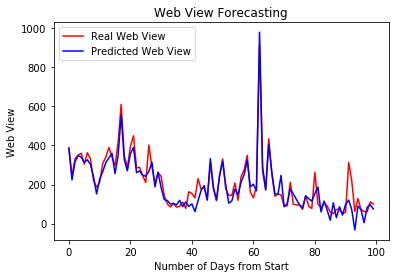

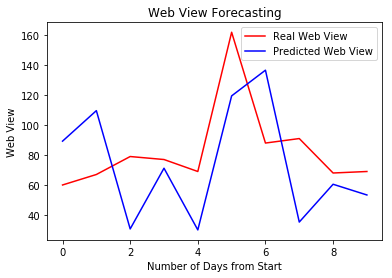

In [13]:


#Visualising Result
plt.figure
plt.plot(y_test[2000:2100], color = 'red', label = 'Real Web View')
plt.plot(y_pred[2000:2100], color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()


plt.figure
plt.plot(y_test[2100:2110], color = 'red', label = 'Real Web View')
plt.plot(y_pred[2100:2110], color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()

In [14]:
regressor.save('model_5000a_7ts_32u_lstm_adam_16b_1e.h5')

In [16]:
print X[4491,0,:], y[4490]
print X_train[4491,:,14], y_train[4491-7:4491]

[  6.   3.  15.  10.   7.   1.   4.] 4.0
[ 0.08571429  0.04285714  0.21428571  0.14285714  0.1         0.01428571
  0.05714286] [[ 0.08571429]
 [ 0.04285714]
 [ 0.21428571]
 [ 0.14285714]
 [ 0.1       ]
 [ 0.01428571]
 [ 0.05714286]]


#### Rows giving good results
11233 - 
13086 - The walking dead